**Section 9B** <br>
3/6/25

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import kagglehub
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import os
from scipy.signal import convolve2d
from tensorflow.keras.utils import to_categorical
import struct
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Task 1: Multilayer Preceptron (MLP)

**A)**

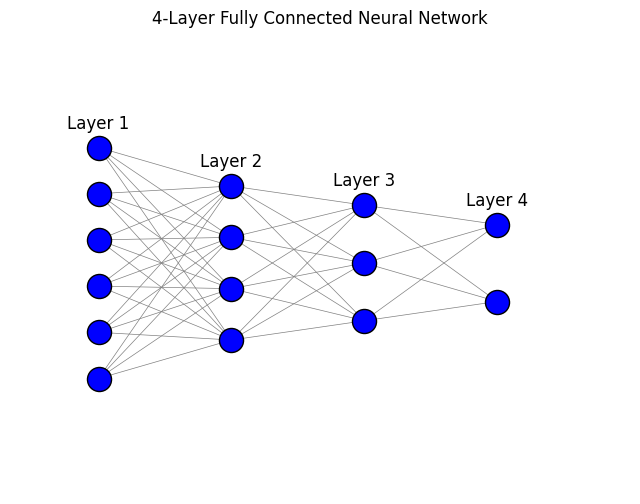

In [2]:
def draw_neural_network(ax, layer_sizes):
    """ Draws a simple schematic of a fully connected neural network. """
    v_spacing = 1.0  # Vertical spacing between neurons
    h_spacing = 1.5  # Horizontal spacing between layers
    
    max_neurons = max(layer_sizes)
    positions = []
    
    # Calculate neuron positions
    for i, size in enumerate(layer_sizes):
        x = i * h_spacing
        y = np.linspace(-size/2, size/2, size) * v_spacing
        positions.append((x, y))
        
    # Draw connections
    for i in range(len(layer_sizes) - 1):
        x1, y1 = positions[i]
        x2, y2 = positions[i + 1]
        for y_start in y1:
            for y_end in y2:
                ax.plot([x1, x2], [y_start, y_end], 'gray', lw=0.5)
    
    # Draw neurons
    for x, y in positions:
        ax.scatter([x] * len(y), y, s=300, color='blue', edgecolors='black', zorder=3)
    
    # Annotate layers
    for i, (x, y) in enumerate(positions):
        ax.text(x, max(y) + 0.5, f'Layer {i+1}', fontsize=12, ha='center')
    
    ax.set_xlim(-1, len(layer_sizes) * h_spacing)
    ax.set_ylim(-max_neurons, max_neurons)
    ax.axis('off')

# Define the neural network structure
layer_sizes = [6, 4, 3, 2]  # Number of neurons in each layer

fig, ax = plt.subplots(figsize=(8, 6))
draw_neural_network(ax, layer_sizes)
plt.title("4-Layer Fully Connected Neural Network")
plt.show()

**B)**

In [32]:
class MLP:
    def __init__(self, layer_sizes, activation='relu', learning_rate=0.01):
        """ Initialize a fully connected MLP. """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.activation_func = self.relu if activation == 'relu' else self.sigmoid
        self.activation_deriv = self.relu_deriv if activation == 'relu' else self.sigmoid_deriv
        
        # Initialize weights and biases
        self.weights = [np.random.randn(o, i) * 0.1 for i, o in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((o, 1)) for o in layer_sizes[1:]]
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_deriv(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def forward(self, x):
        """ Forward pass through the network. """
        activations, zs = [x], []
        for W, b in zip(self.weights, self.biases):
            z = np.dot(W, activations[-1]) + b
            zs.append(z)
            activations.append(self.activation_func(z))
        return activations, zs
    
    def backward(self, x, y):
        """ Backward pass to compute gradients. """
        activations, zs = self.forward(x)
        grads_w, grads_b = [None] * len(self.weights), [None] * len(self.biases)
        # y = y.squeeze()
        # y = y.reshape(10, -1)
        y = y.reshape(10, activations[-1].shape[1])
        print("y shape:", y.shape)
        print("activations[-1] shape:", activations[-1].shape)
        print("zs[-1] shape:", zs[-1].shape)
        
        # Compute output layer error
        delta = (activations[-1] - y) * self.activation_deriv(zs[-1])
        print("delta shape:", delta.shape)
        print("activations[-2] shape:", activations[-2].shape)
        grads_w[-1] = np.einsum('bi,bj->bij', delta, activations[-2]).mean(axis=0)
        grads_b[-1] = delta.mean(axis=0, keepdims=True).T
        
        # Backpropagate error
        for l in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(self.weights[l + 1].T, delta) * self.activation_deriv(zs[l])
            grads_w[l] = np.einsum('bi,bj->bij', delta, activations[l]).mean(axis=0)
            grads_b[l] = delta.mean(axis=0, keepdims=True).T
        
        return grads_w, grads_b
    
    def update_params(self, grads_w, grads_b):
        """ Update weights and biases using gradient descent. """
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads_w[i]
            self.biases[i] -= self.learning_rate * grads_b[i]
    
    def train(self, x, y, epochs=100):
        """ Train the MLP using gradient descent. """
        for epoch in range(epochs):
            grads_w, grads_b = self.backward(x, y)
            self.update_params(grads_w, grads_b)
            if epoch % 10 == 0:
                loss = np.mean((self.forward(x)[0][-1] - y) ** 2)
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Task 2: Convolutional Neural Network (CNN)

**A)**

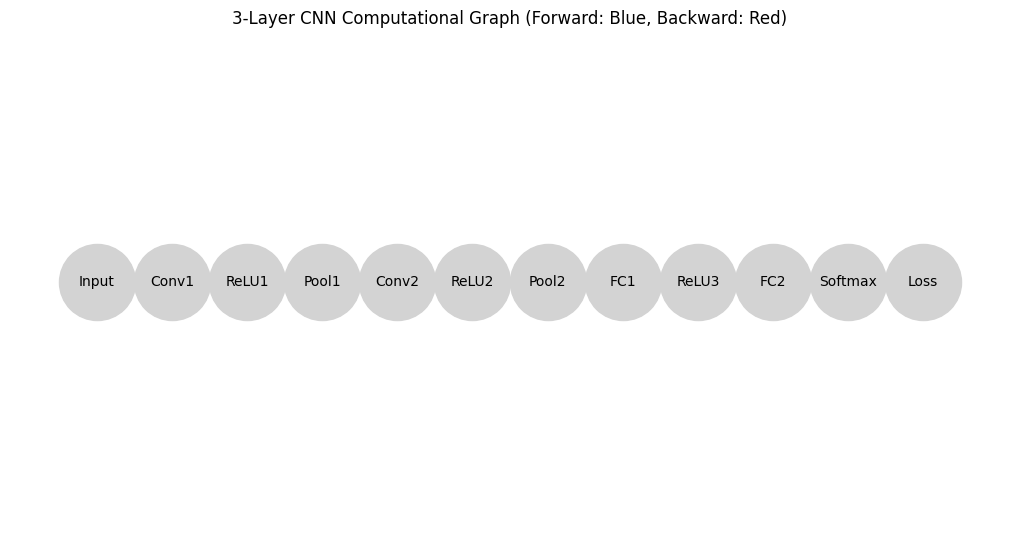

In [6]:
def draw_cnn_graph():
    """Draws a computational graph for a 3-layer CNN with forward and backward propagation."""
    G = nx.DiGraph()
    
    # Define nodes
    layers = {
        "Input": (0, 3),
        "Conv1": (1, 3),
        "ReLU1": (2, 3),
        "Pool1": (3, 3),
        "Conv2": (4, 3),
        "ReLU2": (5, 3),
        "Pool2": (6, 3),
        "FC1": (7, 3),
        "ReLU3": (8, 3),
        "FC2": (9, 3),
        "Softmax": (10, 3),
        "Loss": (11, 3)
    }
    
    # Add forward edges
    forward_edges = [
        ("Input", "Conv1"),
        ("Conv1", "ReLU1"),
        ("ReLU1", "Pool1"),
        ("Pool1", "Conv2"),
        ("Conv2", "ReLU2"),
        ("ReLU2", "Pool2"),
        ("Pool2", "FC1"),
        ("FC1", "ReLU3"),
        ("ReLU3", "FC2"),
        ("FC2", "Softmax"),
        ("Softmax", "Loss")
    ]
    
    # Add backward edges (gradient flow)
    backward_edges = [(b, a) for a, b in forward_edges]
    
    G.add_edges_from(forward_edges, color='blue')
    G.add_edges_from(backward_edges, color='red')
    
    # Draw graph
    pos = layers
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]
    plt.figure(figsize=(10, 5))
    nx.draw(G, pos, with_labels=True, node_color='lightgray', edge_color=edge_colors, node_size=3000, font_size=10)
    plt.title("3-Layer CNN Computational Graph (Forward: Blue, Backward: Red)")
    plt.show()

# Draw the computational graph
draw_cnn_graph()

**B)**

In [15]:
class CNN:
    def __init__(self, input_shape, conv_layers, fc_layers, activation='relu', learning_rate=0.01):
        """ Initialize a simple CNN model. """
        self.input_shape = input_shape
        self.conv_layers = conv_layers
        self.fc_layers = fc_layers
        self.learning_rate = learning_rate
        self.activation_func = self.relu if activation == 'relu' else self.sigmoid
        self.activation_deriv = self.relu_deriv if activation == 'relu' else self.sigmoid_deriv
        
        # Initialize convolutional layers
        self.conv_weights = [np.random.randn(f, *k) * 0.1 for f, k in conv_layers]
        self.conv_biases = [np.zeros((f, 1)) for f, _ in conv_layers]
        
        # Initialize fully connected layers
        self.fc_weights = [np.random.randn(o, i) * 0.1 for i, o in zip(fc_layers[:-1], fc_layers[1:])]
        self.fc_biases = [np.zeros((o, 1)) for o in fc_layers[1:]]
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_deriv(self, x):
        return (x > 0).astype(float)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_deriv(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def forward(self, x):
        """ Forward pass through the CNN. """
        activations, zs = [x], []
        
        # Convolutional layers
        for W, b in zip(self.conv_weights, self.conv_biases):
            z = np.array([convolve2d(xi.squeeze(), Wi.squeeze(), mode='valid') + bi for xi, Wi, bi in zip(x, W, b)])
            zs.append(z)
            activations.append(self.activation_func(z))
        
        # Flatten before FC layers
        x_flattened = activations[-1].flatten().reshape(-1, 1)
        activations.append(x_flattened)
        
        # Fully connected layers
        for W, b in zip(self.fc_weights, self.fc_biases):
            z = np.dot(W, activations[-1]) + b
            zs.append(z)
            activations.append(self.activation_func(z))
        
        return activations, zs
    
    def backward(self, x, y):
        """ Backward pass to compute gradients. """
        activations, zs = self.forward(x)
        grads_w, grads_b = [None] * len(self.fc_weights), [None] * len(self.fc_biases)
        
        # Compute output layer error
        delta = (activations[-1] - y) * self.activation_deriv(zs[-1])
        grads_w[-1] = np.einsum('bi,bj->bij', delta, activations[-2]).mean(axis=0)
        grads_b[-1] = delta.mean(axis=0, keepdims=True).T
        
        # Backpropagate through FC layers
        for l in range(len(self.fc_weights) - 2, -1, -1):
            delta = np.dot(self.fc_weights[l + 1].T, delta) * self.activation_deriv(zs[l])
            grads_w[l] = np.einsum('bi,bj->bij', delta, activations[l]).mean(axis=0)
            grads_b[l] = delta.mean(axis=0, keepdims=True).T
        
        return grads_w, grads_b
    
    def update_params(self, grads_w, grads_b):
        """ Update weights and biases using gradient descent. """
        for i in range(len(self.fc_weights)):
            self.fc_weights[i] -= self.learning_rate * grads_w[i]
            self.fc_biases[i] -= self.learning_rate * grads_b[i]
    
    def train(self, x, y, epochs=100):
        """ Train the CNN using gradient descent. """
        for epoch in range(epochs):
            grads_w, grads_b = self.backward(x, y)
            self.update_params(grads_w, grads_b)
            if epoch % 10 == 0:
                loss = np.mean((self.forward(x)[0][-1] - y) ** 2)
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    def draw_cnn_graph(self):
        """Draws a computational graph for a 3-layer CNN with forward and backward propagation."""
        G = nx.DiGraph()
        layers = {
            "Input": (0, 3), "Conv1": (1, 3), "ReLU1": (2, 3), "Pool1": (3, 3),
            "Conv2": (4, 3), "ReLU2": (5, 3), "Pool2": (6, 3), "FC1": (7, 3),
            "ReLU3": (8, 3), "FC2": (9, 3), "Softmax": (10, 3), "Loss": (11, 3)
        }
        forward_edges = [("Input", "Conv1"), ("Conv1", "ReLU1"), ("ReLU1", "Pool1"),
                         ("Pool1", "Conv2"), ("Conv2", "ReLU2"), ("ReLU2", "Pool2"),
                         ("Pool2", "FC1"), ("FC1", "ReLU3"), ("ReLU3", "FC2"),
                         ("FC2", "Softmax"), ("Softmax", "Loss")]
        backward_edges = [(b, a) for a, b in forward_edges]
        G.add_edges_from(forward_edges, color='blue')
        G.add_edges_from(backward_edges, color='red')
        pos = layers
        edge_colors = [G[u][v]['color'] for u, v in G.edges()]
        plt.figure(figsize=(10, 5))
        nx.draw(G, pos, with_labels=True, node_color='lightgray', edge_color=edge_colors, node_size=3000, font_size=10)
        plt.title("3-Layer CNN Computational Graph (Forward: Blue, Backward: Red)")
        plt.show()

# Task 3: MNIST dataset: Training and validation of MLP and CNN

In [13]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [14]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '../input'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

FileNotFoundError: [Errno 2] No such file or directory: '../input/train-labels-idx1-ubyte/train-labels-idx1-ubyte'

In [11]:
# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

100%|██████████| 22.0M/22.0M [00:01<00:00, 18.7MB/s]

Extracting model files...


Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [7]:
# Function to load IDX files
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.fromfile(f, dtype=np.uint8).reshape(num, rows, cols)
    return data / 255.0  # Normalize pixel values

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Load dataset
data_path = "./archive"  # Change this if the folder is elsewhere
x_train = load_mnist_images(os.path.join(data_path, "train-images.idx3-ubyte"))
y_train = load_mnist_labels(os.path.join(data_path, "train-labels.idx1-ubyte"))
x_test = load_mnist_images(os.path.join(data_path, "t10k-images.idx3-ubyte"))
y_test = load_mnist_labels(os.path.join(data_path, "t10k-labels.idx1-ubyte"))

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape for CNN: (N, 28, 28, 1) and for MLP: (N, 784)
x_train_cnn, x_test_cnn = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train_mlp, x_test_mlp = x_train.reshape(-1, 784), x_test.reshape(-1, 784)

# Split dataset into 80-20 train-test
x_train_cnn, x_val_cnn, y_train_cnn, y_val_cnn = train_test_split(x_train_cnn, y_train, test_size=0.2, random_state=42)
x_train_mlp, x_val_mlp, y_train_mlp, y_val_mlp = train_test_split(x_train_mlp, y_train, test_size=0.2, random_state=42)

# Now, train your MLP and CNN models using x_train_mlp, y_train_mlp and x_train_cnn, y_train_cnn
print("Data loaded and split successfully!")

Data loaded and split successfully!


In [35]:
# Assuming x_train and y_train contain the full dataset
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Reshape the images into 1D vectors (flatten 28x28 images)
x_train_mlp = x_train.reshape(x_train.shape[0], -1).T  # Shape (784, num_samples)
x_val_mlp = x_val.reshape(x_val.shape[0], -1).T  # Shape (784, num_samples)

# Convert labels to one-hot encoding
y_train_mlp = to_categorical(y_train, num_classes=10)  # Shape should be (num_samples, 10)
y_train_mlp.reshape(y_train_mlp.shape[0], 10)  # Ensure it is (num_samples, 10)
print("Before transpose, y_train_mlp shape:", y_train_mlp.shape)

y_train_mlp = y_train_mlp.T  # Now it should be (10, num_samples)
print("After transpose, y_train_mlp shape:", y_train_mlp.shape)
y_val_mlp = to_categorical(y_val, num_classes=10).T
print("y_val_mlp shape:", y_val_mlp.shape)

# Define the MLP model
mlp_model = MLP(layer_sizes=[784, 128, 64, 10], activation='relu', learning_rate=0.01)

# Train the MLP model
mlp_model.train(x_train_mlp, y_train_mlp, epochs=50)

ValueError: cannot reshape array of size 329600 into shape (3296,10)

In [11]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Assuming you have trained models and predictions
y_true_mlp = np.argmax(y_val_mlp, axis=1)  # Convert one-hot encoding to labels
y_pred_mlp = np.argmax(mlp_model.predict(x_val_mlp), axis=1)  # Get MLP predictions

y_true_cnn = np.argmax(y_val_cnn, axis=1)
y_pred_cnn = np.argmax(cnn_model.predict(x_val_cnn), axis=1)

# Plot confusion matrices
plot_confusion_matrix(y_true_mlp, y_pred_mlp, title="MLP Confusion Matrix")
plot_confusion_matrix(y_true_cnn, y_pred_cnn, title="CNN Confusion Matrix")

NameError: name 'mlp_model' is not defined